# 1.5 「ファインチューニング」で精度向上を実現する方法

- 本ファイルでは、学習済みのVGGモデルを使用し、ファインチューニングでアリとハチの画像を分類するモデルを学習します



# 学習目標

1.	PyTorchでGPUを使用する実装コードを書けるようになる
2.	最適化手法の設定において、層ごとに異なる学習率を設定したファインチューニングを実装できるようになる
3.	学習したネットワークを保存・ロードできるようになる



# 事前準備

- 1.4節で解説したAWS EC2 のGPUインスタンスを使用します


In [1]:
# パッケージのimport
import random
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

In [2]:
print(torch.__version__, torch.cuda.is_available())

2.0.0+cu117 False


In [3]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [4]:
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

batch_size = 32

In [5]:
OUTPUT_FEATURES = 2

LEARNING_RATIO = 0.001
MOMENTUM = 0.0
# WEIGHT_DECAY = 1e-3

NUM_EPOCHS = 8

# MLflow

In [6]:
import mlflow

In [19]:
# experimentの作成(読み込み)
experiment_id = mlflow.set_experiment("PyTorch_Advanced")  # experimentの設定. 無ければ新規に作成.
print(experiment_id.experiment_id)

919876265981551812


# DatasetとDataLoaderを作成

In [8]:
# 1.3節で作成したクラスを同じフォルダにあるmake_dataset_dataloader.pyに記載して使用
from utils.dataloader_image_classification import (
    HymenopteraDataset,
    ImageTransform,
    make_datapath_list,
)

# アリとハチの画像へのファイルパスのリストを作成する
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

# Datasetを作成する
train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase="train"
)

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase="val"
)


# DataLoaderを作成する
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


# モデルを学習させる関数を作成

In [40]:
def plot_history(name, history):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
    axes[0].plot(
        range(len(history["train"]["loss"])),
        history["train"]["loss"],
        "r-o",
        label=f"{name}-train",
    )
    axes[0].plot(
        range(len(history["val"]["loss"])),
        history["val"]["loss"],
        "b--s",
        label=f"{name}-val",
    )
    axes[0].set_xlabel("Epochs", size=14)
    axes[0].set_ylabel("Loss", size=14)
    axes[0].tick_params(labelsize=12)
    axes[0].grid()
    axes[0].legend()

    axes[1].plot(
        range(len(history["train"]["acc"])),
        history["train"]["acc"],
        "r-o",
        label=f"{name}-train",
    )
    axes[1].plot(
        range(len(history["val"]["acc"])),
        history["val"]["acc"],
        "b--s",
        label=f"{name}-val",
    )
    axes[1].set_xlabel("Epochs", size=14)
    axes[1].set_ylabel("Accuracy", size=14)
    axes[1].tick_params(labelsize=12)
    axes[1].grid()
    axes[1].legend()
    plt.suptitle(f"{name}", size=16)
    # plt.show()
    return fig

In [55]:
def train_model(name, net, dataloaders_dict, criterion, optimizer, num_epochs):
    # 初期設定
    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # epochのループ
    history = {}
    history["train"] = {}
    history["val"] = {}
    history["train"]["loss"] = []
    history["train"]["acc"] = []
    history["val"]["loss"] = []
    history["val"]["acc"] = []

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch + 1, num_epochs))
        # print("-------------")

        # epochごとの訓練と検証のループ
        for phase in ["train", "val"]:
            if phase == "train":
                net.train()  # モデルを訓練モードに
            else:
                net.eval()  # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            # if (epoch == 0) and (phase == "train"):
            #     continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                # GPUが使えるならGPUにデータを送る
                inputs = inputs.to(device)
                labels = labels.to(device)

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == "train"):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測

                    # 訓練時はバックプロパゲーション
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                    # 結果の計算
                    epoch_loss += loss.item() * inputs.size(0)  # lossの合計を更新
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            history[phase]["loss"].append(epoch_loss)
            history[phase]["acc"].append(epoch_acc)

            # MLflow: track metrics
            mlflow.log_metric(f"{phase}_loss", epoch_loss, step=epoch)  # Train Loss
            mlflow.log_metric(f"{phase}_acc", epoch_acc, step=epoch)  # Train Loss

    return history

# 損失関数を定義

In [56]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

# ネットワークモデルの作成fc

In [57]:
resnet_models = {
    "resnet18": (models.resnet18, models.ResNet18_Weights.DEFAULT),
    "resnet34": (models.resnet34, models.ResNet34_Weights.DEFAULT),
    "resnet50": (models.resnet50, models.ResNet50_Weights.DEFAULT),
    "resnet101": (models.resnet101, models.ResNet101_Weights.DEFAULT),
    "resnet152": (models.resnet152, models.ResNet152_Weights.DEFAULT),
}

In [59]:
mlflow.end_run()

Model: resnet18 512
使用デバイス： cpu
Epoch 1/8


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


train Loss: 0.7634 Acc: 0.4979


100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


val Loss: 0.6736 Acc: 0.5882
Epoch 2/8


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


train Loss: 0.6970 Acc: 0.5761


100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


val Loss: 0.6398 Acc: 0.6275
Epoch 3/8


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


train Loss: 0.6662 Acc: 0.5926


100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


val Loss: 0.6075 Acc: 0.6928
Epoch 4/8


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


train Loss: 0.6184 Acc: 0.6461


100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


val Loss: 0.5788 Acc: 0.7190
Epoch 5/8


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


train Loss: 0.6005 Acc: 0.6749


100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


val Loss: 0.5570 Acc: 0.7582
Epoch 6/8


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


train Loss: 0.5928 Acc: 0.6872


100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


val Loss: 0.5352 Acc: 0.7712
Epoch 7/8


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


train Loss: 0.5607 Acc: 0.7490


100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


val Loss: 0.5090 Acc: 0.8105
Epoch 8/8


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


train Loss: 0.5277 Acc: 0.7819


100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


val Loss: 0.4907 Acc: 0.8105
Model: resnet34 512
使用デバイス： cpu
Epoch 1/8


100%|██████████| 8/8 [00:16<00:00,  2.07s/it]


train Loss: 0.7456 Acc: 0.5103


100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


val Loss: 0.7014 Acc: 0.5556
Epoch 2/8


100%|██████████| 8/8 [00:16<00:00,  2.05s/it]


train Loss: 0.6967 Acc: 0.5514


100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


val Loss: 0.6400 Acc: 0.6078
Epoch 3/8


100%|██████████| 8/8 [00:16<00:00,  2.05s/it]


train Loss: 0.6305 Acc: 0.6708


100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


val Loss: 0.6079 Acc: 0.6536
Epoch 4/8


100%|██████████| 8/8 [00:16<00:00,  2.05s/it]


train Loss: 0.6046 Acc: 0.6790


100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


val Loss: 0.5761 Acc: 0.7124
Epoch 5/8


100%|██████████| 8/8 [00:16<00:00,  2.07s/it]


train Loss: 0.5702 Acc: 0.7119


100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


val Loss: 0.5469 Acc: 0.7386
Epoch 6/8


100%|██████████| 8/8 [00:16<00:00,  2.06s/it]


train Loss: 0.5368 Acc: 0.7695


100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


val Loss: 0.5301 Acc: 0.7320
Epoch 7/8


100%|██████████| 8/8 [00:16<00:00,  2.06s/it]


train Loss: 0.5036 Acc: 0.8107


100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


val Loss: 0.5079 Acc: 0.7451
Epoch 8/8


100%|██████████| 8/8 [00:16<00:00,  2.07s/it]


train Loss: 0.4960 Acc: 0.8066


100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


val Loss: 0.4821 Acc: 0.7974
Model: resnet50 2048
使用デバイス： cpu
Epoch 1/8


100%|██████████| 8/8 [00:30<00:00,  3.83s/it]


train Loss: 0.6800 Acc: 0.5473


100%|██████████| 5/5 [00:15<00:00,  3.19s/it]


val Loss: 0.6645 Acc: 0.6471
Epoch 2/8


100%|██████████| 8/8 [00:30<00:00,  3.79s/it]


train Loss: 0.6664 Acc: 0.6173


100%|██████████| 5/5 [00:15<00:00,  3.05s/it]


val Loss: 0.6560 Acc: 0.7320
Epoch 3/8


100%|██████████| 8/8 [00:30<00:00,  3.85s/it]


train Loss: 0.6602 Acc: 0.6790


100%|██████████| 5/5 [00:15<00:00,  3.20s/it]


val Loss: 0.6495 Acc: 0.7386
Epoch 4/8


100%|██████████| 8/8 [00:30<00:00,  3.86s/it]


train Loss: 0.6498 Acc: 0.7366


100%|██████████| 5/5 [00:15<00:00,  3.18s/it]


val Loss: 0.6423 Acc: 0.7582
Epoch 5/8


100%|██████████| 8/8 [00:30<00:00,  3.84s/it]


train Loss: 0.6366 Acc: 0.7572


100%|██████████| 5/5 [00:15<00:00,  3.12s/it]


val Loss: 0.6343 Acc: 0.7843
Epoch 6/8


100%|██████████| 8/8 [00:30<00:00,  3.84s/it]


train Loss: 0.6375 Acc: 0.7366


100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


val Loss: 0.6270 Acc: 0.8170
Epoch 7/8


100%|██████████| 8/8 [00:30<00:00,  3.78s/it]


train Loss: 0.6221 Acc: 0.7860


100%|██████████| 5/5 [00:15<00:00,  3.07s/it]


val Loss: 0.6175 Acc: 0.8235
Epoch 8/8


100%|██████████| 8/8 [00:30<00:00,  3.84s/it]


train Loss: 0.6127 Acc: 0.8519


100%|██████████| 5/5 [00:15<00:00,  3.11s/it]


val Loss: 0.6104 Acc: 0.8497
Model: resnet101 2048
使用デバイス： cpu
Epoch 1/8


100%|██████████| 8/8 [00:48<00:00,  6.04s/it]


train Loss: 0.6771 Acc: 0.6296


100%|██████████| 5/5 [00:24<00:00,  4.93s/it]


val Loss: 0.6674 Acc: 0.6209
Epoch 2/8


100%|██████████| 8/8 [00:48<00:00,  6.07s/it]


train Loss: 0.6679 Acc: 0.6502


100%|██████████| 5/5 [00:24<00:00,  4.91s/it]


val Loss: 0.6526 Acc: 0.7124
Epoch 3/8


100%|██████████| 8/8 [00:47<00:00,  6.00s/it]


train Loss: 0.6446 Acc: 0.7119


100%|██████████| 5/5 [00:25<00:00,  5.01s/it]


val Loss: 0.6406 Acc: 0.7190
Epoch 4/8


100%|██████████| 8/8 [00:48<00:00,  6.06s/it]


train Loss: 0.6262 Acc: 0.7531


100%|██████████| 5/5 [00:25<00:00,  5.05s/it]


val Loss: 0.6247 Acc: 0.7712
Epoch 5/8


100%|██████████| 8/8 [00:48<00:00,  6.06s/it]


train Loss: 0.6102 Acc: 0.8354


100%|██████████| 5/5 [00:30<00:00,  6.06s/it]


val Loss: 0.6120 Acc: 0.8235
Epoch 6/8


100%|██████████| 8/8 [00:47<00:00,  5.98s/it]


train Loss: 0.6128 Acc: 0.7901


100%|██████████| 5/5 [00:24<00:00,  4.98s/it]


val Loss: 0.6014 Acc: 0.8301
Epoch 7/8


100%|██████████| 8/8 [00:47<00:00,  5.97s/it]


train Loss: 0.5938 Acc: 0.8148


100%|██████████| 5/5 [00:24<00:00,  4.84s/it]


val Loss: 0.5876 Acc: 0.8431
Epoch 8/8


100%|██████████| 8/8 [00:47<00:00,  5.95s/it]


train Loss: 0.5760 Acc: 0.8642


100%|██████████| 5/5 [00:24<00:00,  4.94s/it]


val Loss: 0.5765 Acc: 0.8497
Model: resnet152 2048
使用デバイス： cpu
Epoch 1/8


  0%|          | 0/8 [00:03<?, ?it/s]


KeyboardInterrupt: 

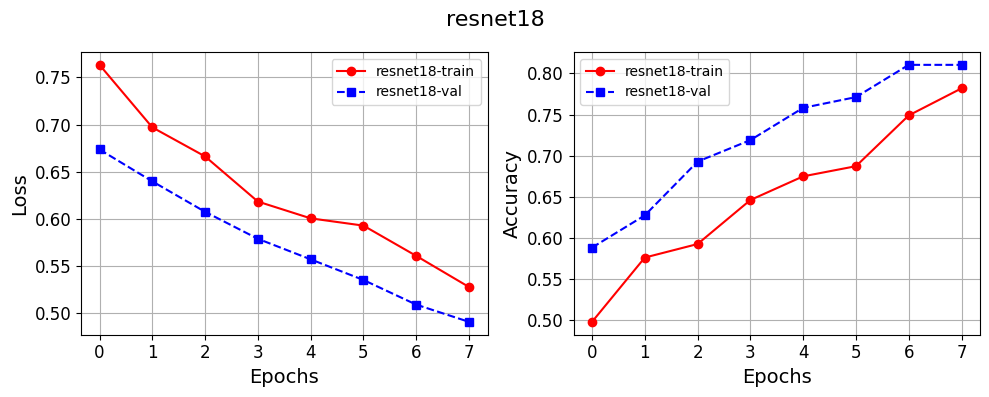

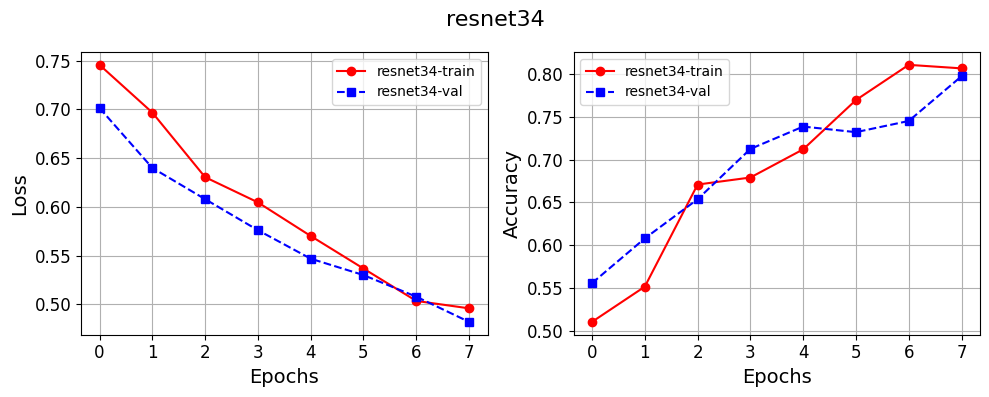

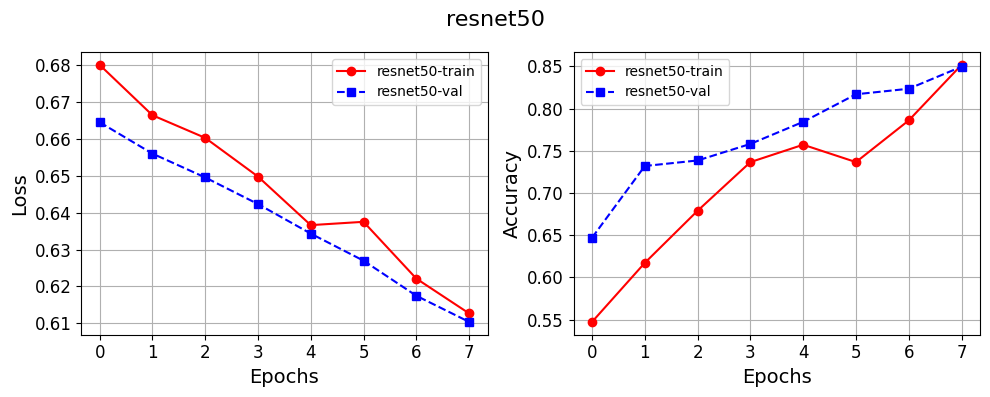

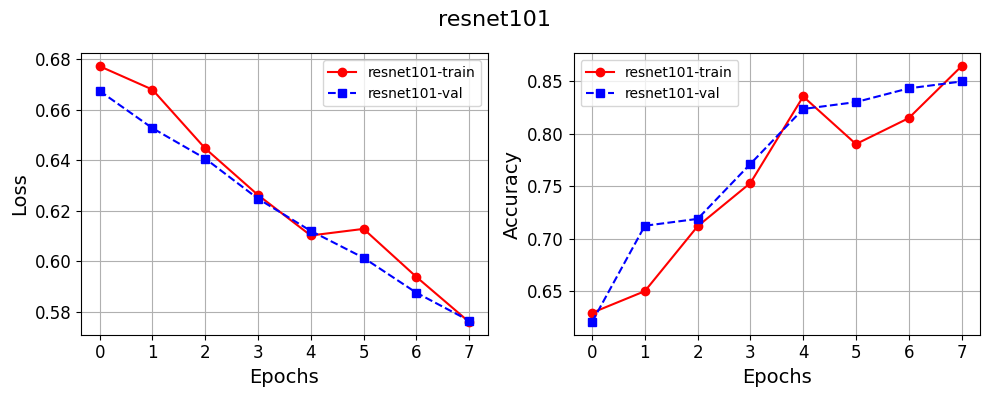

In [60]:
resnet_results = {}
for name, (model, weights) in resnet_models.items():
    # MLflow: runの作成
    now = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_name = f"{name}_SGD_LR{LEARNING_RATIO}_EPOCH{NUM_EPOCHS}_{now}"
    mlflow_run = mlflow.start_run(
        experiment_id=experiment_id.experiment_id,  # set_experimentの返り値を入れる.
        run_name=run_name,  # run_nameに、作成時刻を用いるようにした.
    )

    # MLflow: track params
    mlflow.log_param("Learning_ratio", LEARNING_RATIO)  # Learning ratio
    mlflow.log_param("Num_epochs", NUM_EPOCHS)  # num of Epochs
    mlflow.log_param("Optimizer", "SGD")  # optimizer
    mlflow.log_param("SGD_Momentum", MOMENTUM)

    _net = model(weights=weights)
    last_in_features = _net.fc.in_features
    _net.fc = nn.Linear(in_features=last_in_features, out_features=OUTPUT_FEATURES)
    _net.train()
    print("Model:", name, last_in_features)

    # 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
    for param in _net.parameters():
        param.requires_grad = False

    params_to_update = []
    for param in _net.fc.parameters():
        param.requires_grad = True
        params_to_update.append(param)

    optimizer = optim.SGD(
        params_to_update,
        lr=LEARNING_RATIO,
        momentum=MOMENTUM,
    )
    # optimizer = optim.Adam(
    #     params_to_update,
    #     lr=LEARNING_RATIO,
    #     weight_decay=WEIGHT_DECAY,
    # )

    history = train_model(
        name, _net, dataloaders_dict, criterion, optimizer, num_epochs=NUM_EPOCHS
    )
    resnet_results[name] = history

    # # MLflow: track figure
    # figure = plot_history(name, history)
    # mlflow.log_figure(figure, "history.png")

    # MLflowL end run
    mlflow.end_run()

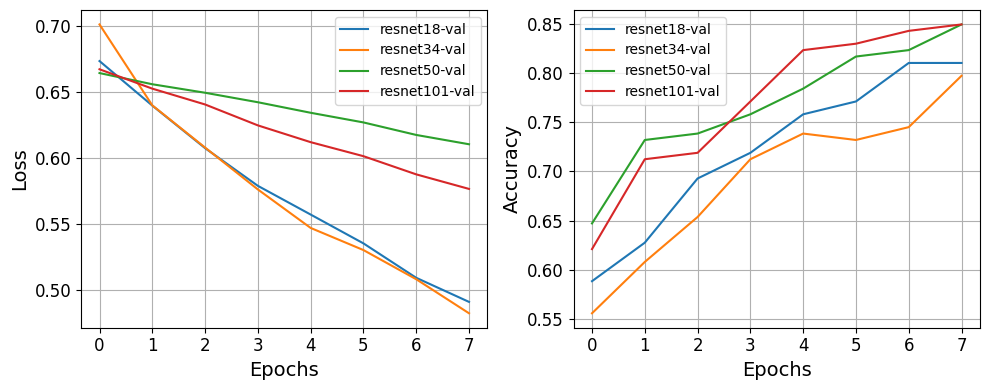

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
for model in resnet_results.keys():
    # for phase in resnet_results[model].keys():
    for phase in ["val"]:
        axes[0].plot(
            range(len(resnet_results[model][phase]["loss"])),
            resnet_results[model][phase]["loss"],
            # plot_style[phase],
            label=f"{model}-{phase}",
        )
axes[0].set_xlabel("Epochs", size=14)
axes[0].set_ylabel("Loss", size=14)
axes[0].tick_params(labelsize=12)
axes[0].grid()
axes[0].legend()

for model in resnet_results.keys():
    # for phase in resnet_results[model].keys():
    for phase in ["val"]:
        axes[1].plot(
            range(len(resnet_results[model][phase]["acc"])),
            resnet_results[model][phase]["acc"],
            # plot_style[phase],
            label=f"{model}-{phase}",
        )
axes[1].set_xlabel("Epochs", size=14)
axes[1].set_ylabel("Accuracy", size=14)
axes[1].tick_params(labelsize=12)
axes[1].grid()
axes[1].legend()
plt.show()

# 学習したネットワークを保存・ロード

In [ ]:
# # PyTorchのネットワークパラメータの保存
# save_path = "./weights_fine_tuning.pth"
# torch.save(net.state_dict(), save_path)

In [ ]:
# # PyTorchのネットワークパラメータのロード
# load_path = "./weights_fine_tuning.pth"
# load_weights = torch.load(load_path)
# net.load_state_dict(load_weights)

# # GPU上で保存された重みをCPU上でロードする場合
# load_weights = torch.load(load_path, map_location={"cuda:0": "cpu"})
# net.load_state_dict(load_weights)

以上